This IPython Notebook handles the training and evaluation of a neural net that produces a heatmap of edge likelihood from an unsaturated image

In [1]:
# Handle imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython import embed


In [139]:
class ImageGenerator():
    def __init__(self, shape: tuple, batchSize: int):
        self.shape = np.array(shape)

    def generate_image(self) -> np.ndarray:
        shapeBGR = (self.shape[1], self.shape[0], 3)
        imageBGR = np.zeros(shapeBGR, 'uint8')

        # make array of corner indeces
        corners = np.array([[0,0],[0,1],[1,1],[1,0],[0,0],[0,1],[1,1],[1,0]]) * (self.shape - 1)
        b = np.random.randint(0,4)  # random starting corner
        c = np.random.randint(1,4) + b  # pick 1-3 total corners

        # pick random edge points for edge line
        rands = np.random.random(2)
        dir0 = corners[b] - corners[b-1]
        dir1 = corners[c] - corners[c-1]
        point0 = dir0*rands[0] + corners[b-1]
        point1 = dir1*rands[1] + corners[c-1]

        # construct polygon
        polygon = corners[b:c]
        polygon = np.concatenate(([point0], polygon, [point1]), axis=0)
        polygon = polygon.astype(np.int32)
        polygon = np.expand_dims(polygon, 1)
        cv2.fillPoly(imageBGR, [polygon], (255,255,255), lineType=cv2.LINE_AA)

        image = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY)

        edgeImageBGR = np.zeros(shapeBGR, 'uint8')
        edge = [0, -1]
        cv2.polylines(edgeImageBGR, [polygon[edge]], False, (255,255,255), lineType=cv2.LINE_AA)

        edgeImage = cv2.cvtColor(edgeImageBGR, cv2.COLOR_BGR2GRAY)

        return image, edgeImage



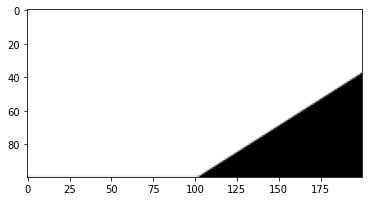

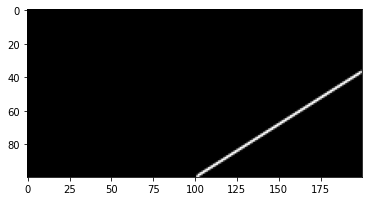

In [152]:
generator = ImageGenerator((200, 100), 1)
img, edgeImg = generator.generate_image()

def imshow(image: np.ndarray):
    if image.ndim == 2:
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    elif image.ndim == 3:
        plt.imshow(image[:,:,::-1])
    else:
        raise(ValueError)
    plt.show()

imshow(img)
imshow(edgeImg)

In [ ]:
# Test for the random polygon algorithm
a = np.array([[0,0],[0,2],[1,2],[1,0],[0,0],[0,2],[1,2],[1,0]])
b = np.random.randint(0,4)
c = np.random.randint(1,4) + b
print(b, c)
rands = np.random.random(2)
point0 = (a[b] - a[b-1])*rands[0] + a[b-1]
point1 = (a[c] - a[c-1])*rands[1] + a[c-1]

poly = a[b:c]
poly = np.concatenate(([point0], poly, [point1]), axis=0)

print(poly)

1 3
[[0.         0.90314412]
 [0.         2.        ]
 [1.         2.        ]
 [1.         1.88318445]]
